In [44]:
# !pip install lightning --target=/kaggle/working/libs

In [45]:
# !pip install lightning wandb

In [46]:
from path import Path
import sys
sys.path += ["/kaggle/working/libs"]

In [47]:
import wandb

from scipy import stats

import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import weight_norm

import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger, TensorBoardLogger
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping, StochasticWeightAveraging
from lightning.pytorch.tuner import Tuner


from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from typing import Callable, Optional, List, Tuple

import pandas as pd
import numpy as np

import pprint
from numpy.typing import ArrayLike

from pathlib import Path

import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API")


In [48]:
wandb.login(key=wandb_api_key)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [49]:
print(torch.__version__)
print(pl.__version__)

2.1.2+cpu
2.3.2


# Building source model

In [50]:
CONFIG = dict(
            features=['timestamp', 'Weather_Temperature_Celsius', 'Weather_Relative_Humidity', 'Global_Horizontal_Radiation', 'Active_Power'],
            label='Active_Power',
            input_size=12,
            horizon=1,
            batch_size=128,
            cv_iter=[0.5, 0.7, 0.9],
            train_dataset_size = 0.6,
            val_dataset_size=0.2,
            test_dataset_size=0.2,
            num_channels = [26] * 4,
            in_channels = 4,
            learning_rate=0.00002517,
            train=False
            )

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})


def plot(historical, prediction, actual, ylabel="Radiation"):
    x = np.arange(len(historical) + 1)
    print(prediction, actual)
    historical = np.append(historical, actual)

    print(len(x), len(historical), print(x[-1]))
    plt.plot(x, historical, linestyle="--", label="hist")
    plt.scatter(x[-1], prediction, color="green", marker="*", label="pred")
    plt.scatter(x[-1], actual, marker="o", label="act")
    axs = plt.gca()
    axs.yaxis.get_ticklocs(minor=True)
    axs.minorticks_on()

    #     axs.tick_params(axis='x', which='minor', bottom=False)
    plt.legend()
    plt.title("Prediction of the radiation")
    plt.ylabel(ylabel)
    plt.xlabel("Time steps")
    plt.show()


def plot_pred_vs_act(preds, actuals, ylabel="Radiation"):
    x = np.arange(len(preds))
    fig = plt.figure()
    plt.plot(x, preds, "*g-", label="pred")
    plt.plot(x, actuals, "xr-", label="act")
    plt.legend()
    plt.title("Prediction vs Actuals")
    plt.ylabel(ylabel)
    plt.xlabel("Time steps")
    plt.show()


In [52]:
class DKACS(Dataset):
    def __init__(self, path: str, horizon: int, input_size: int, transform: Optional[List[Callable]]=None, target_transform: Optional[List[Callable]]=None,  data_path='./'):
        self.data: pd.DataFrame = pd.read_csv(path).values
#         self.data = data.values.astype(np.float32)
        self.h = horizon
        self.w = input_size
        self.transform = transform
        self.target_transform = target_transform
        self.features, self.label = self.create_windows()
        
        
    def create_windows(self):
        total_possible_window_size = len(self.data) - self.w - self.h - 1
        features = np.zeros(shape=(total_possible_window_size, self.data.shape[1], self.w), dtype=np.float32)
        label = np.zeros(shape=(total_possible_window_size, self.h), dtype=np.float32)
        for i in range(total_possible_window_size):
            features[i] = np.transpose(self.data[i:i+self.w])
            label[i] = self.data[i+self.w+self.h-1, -1]
        return features, label
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = torch.from_numpy(self.features[idx].astype(np.float32))
        label = torch.from_numpy(self.label[idx].astype(np.float32))
        
        return features, label

In [53]:
class DKASCDataModule(pl.LightningDataModule):
    def __init__(self, input_size: int = 72, horizon: int = 1, batch_size: int = 32):
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.input_size = input_size
        self.horizon = horizon
    
    def prepare_data(self):
        pass
        
    def setup(self, stage=None):
        if stage == 'fit':
            self.dkasc_train = DKACS("/kaggle/input/dkasc-dataset/DKASC_train.csv", self.horizon, self.input_size)
            self.dkasc_val = DKACS("/kaggle/input/dkasc-dataset/DKASC_val.csv", self.horizon, self.input_size)
        
        if stage == 'test':
            self.dkasc_test = DKACS("/kaggle/input/dkasc-dataset/DKASC_test.csv", self.horizon, self.input_size)
        
        if stage == 'predict':
            self.dkasc_test = DKACS("/kaggle/input/dkasc-dataset/DKASC_test.csv", self.horizon, self.input_size)

    
    def train_dataloader(self):
        return DataLoader(self.dkasc_train, shuffle=False, pin_memory=True, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(self.dkasc_val, shuffle=False, pin_memory=True, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    def test_dataloader(self):
        return DataLoader(self.dkasc_test, shuffle=False, pin_memory=True, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    def predict_dataloader(self):
        return DataLoader(self.dkasc_test, shuffle=False, pin_memory=True, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    
    
    def teardown(self, stage):
        if stage == 'fit':
            del self.dkasc_train
            del self.dkasc_val
            
        if stage == 'test':
            del self.dkasc_test

In [54]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class PermuteLayer(torch.nn.Module):
    dims: tuple[int, ...]

    def __init__(self, dims: tuple[int, ...]) -> None:
        super().__init__()
        self.dims = dims

    def forward(self, input: torch.Tensor) -> torch.Tensor:
#         if not isinstance(input, torch.Tensor):
#             input = input[0]
        return input.permute(*self.dims)
    
class ECALayer(nn.Module):
    """Constructs a ECA module.

    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size-1, padding=(k_size-1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)
        
        return x * y.expand_as(x)
    

activation_fn = dict(
    relu=nn.ReLU,
    tanh=nn.Tanh,
    leaky_relu=nn.LeakyReLU,
    sigmoid=nn.Sigmoid,
    elu=nn.ELU,
    gelu=nn.GELU,
    selu=nn.SELU,
    softmax=nn.Softmax,
    log_softmax=nn.LogSoftmax,
)

kernel_init_fn = dict(
    xavier_uniform=nn.init.xavier_uniform_,
    xavier_normal=nn.init.xavier_normal_,
    kaiming_uniform=nn.init.kaiming_uniform_,
    kaiming_normal=nn.init.kaiming_normal_,
    normal=nn.init.normal_,
    uniform=nn.init.uniform_,
)

def _check_activation_arg(
        activation,
        arg_name,
        ):
    if activation is None and arg_name == 'output_activation':
        return
    if isinstance( activation, str ):
        if activation not in activation_fn.keys():
            raise ValueError(
                f"""
                If argument '{arg_name}' is a string, it must be one of:
                {activation_fn.keys()}. However, you may also pass any
                torch.nn.Module object as the 'activation' argument.
                """
                )
    elif not isinstance( activation, nn.Module ):
        raise ValueError(
            f"""
            The argument '{arg_name}' must either be a valid string or
            a torch.nn.Module object, but {activation} was passed,
            which is of type {type(activation)}.
            """
            )
    return

def _check_generic_input_arg(
        arg,
        arg_name,
        allowed_values,
        ):
    if arg not in allowed_values:
        raise ValueError(
            f"""
            Argument '{arg_name}' must be one of: {allowed_values},
            but {arg} was passed.
            """
            )
    return

def get_kernel_init_fn(
        name: str,
        activation: str,
        ) -> Tuple[ nn.Module, dict ]:
    if isinstance( activation, nn.Module ):
        return kernel_init_fn[ name ], dict()
    # TODO: this means no gain is used for custom activation functions
        
    if name not in kernel_init_fn.keys():
        raise ValueError(
            f"Argument 'kernel_initializer' must be one of: {kernel_init_fn.keys()}"
            )
    if name in [ 'xavier_uniform', 'xavier_normal' ]:
        if activation in [ 'gelu', 'elu', 'softmax', 'log_softmax' ]:
            warnings.warn(
                f"""
                Argument 'kernel_initializer' {name}
                is not compatible with activation {activation} in the
                sense that the gain is not calculated automatically.
                Here, a gain of sqrt(2) (like in ReLu) is used.
                This might lead to suboptimal results.
                """
                )
            gain = np.sqrt( 2 )
        else:
            gain = nn.init.calculate_gain( activation )
        kernel_init_kw = dict( gain=gain )
    elif name in [ 'kaiming_uniform', 'kaiming_normal' ]:
        if activation in [ 'gelu', 'elu', 'softmax', 'log_softmax' ]:
            raise ValueError(
                f"""
                Argument 'kernel_initializer' {name}
                is not compatible with activation {activation}.
                It is recommended to use 'relu' or 'leaky_relu'.
                """
                )
        else:
            nonlinearity = activation
        kernel_init_kw = dict( nonlinearity=nonlinearity )
    else:
        kernel_init_kw = dict()
    
    return kernel_init_fn[ name ], kernel_init_kw



class CausalConv1d(nn.Conv1d):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride = 1,
            dilation = 1,
            groups = 1,
            bias = True,
            buffer = None,
            lookahead = 0,
            **kwargs,
            ):
        
        super(CausalConv1d, self).__init__(
            in_channels = in_channels,
            out_channels = out_channels,
            kernel_size = kernel_size,
            stride = stride,
            padding = 0,
            dilation = dilation,
            groups = groups,
            bias = bias,
            **kwargs,
            )
        
        self.pad_len = (kernel_size - 1) * dilation
        if lookahead > self.pad_len//2:
            lookahead = self.pad_len//2
        self.lookahead = lookahead

        self.buffer_len = self.pad_len - self.lookahead
        #print( 'pad len:', self.pad_len )
        #print( 'lookahead:', self.lookahead )
        #print( 'buffer len:', self.buffer_len )
        
        if buffer is None:
            buffer = torch.zeros(
                1,
                in_channels,
                self.pad_len,
                )
            
        self.register_buffer(
            'buffer',
            buffer,
            )
        
        return
    
    def _forward(self, x):
        p = nn.ConstantPad1d(
            ( self.buffer_len, self.lookahead ),
            0.0,
            )
        x = p(x)
        x = super().forward(x)
        return x

    def forward(
            self,
            x,
            inference=False,
            ):
        if inference:
            x = self.inference(x)
        else:
            x = self._forward(x)
        return x
    
    def inference(self, x):
        if x.shape[0] != 1:
            raise ValueError(
                f"""
                Streaming inference of CausalConv1D layer only supports
                a batch size of 1, but batch size is {x.shape[0]}.
                """
                )
        if x.shape[2] < self.lookahead + 1:
            raise ValueError(
                f"""
                Input time dimension {x.shape[2]} is too short for causal
                inference with lookahead {self.lookahead}. You must pass at
                least lookhead + 1 time steps ({self.lookahead + 1}).
                """
                )
        x = torch.cat(
            (self.buffer, x),
            -1,
            )
        if self.lookahead > 0:
            self.buffer = x[:, :, -(self.pad_len+self.lookahead) : -self.lookahead ]
        else:
            self.buffer = x[:, :, -self.buffer_len: ]
        x = super().forward(x)
        return x
    
    def reset_buffer(self):
        self.buffer.zero_()
        if self.buffer.shape[2] != self.pad_len:
            raise ValueError(
                f"""
                Buffer shape {self.buffer.shape} does not match the expected
                shape (1, {self.in_channels}, {self.pad_len}).
                """
                )
        return



class TemporalConv1d(nn.Conv1d):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            dilation=1,
            groups=1,
            bias=True,
            **kwargs,
            ):
        
        self.pad_len = (kernel_size-1) * dilation

        super(TemporalConv1d, self).__init__(
            in_channels = in_channels,
            out_channels = out_channels,
            kernel_size = kernel_size,
            stride = stride,
            padding = self.pad_len // 2,
            dilation = dilation,
            groups = groups,
            bias = bias,
            **kwargs,
            )
        
        return
    
    def forward(self, x, inference=None):
        # Implementation of 'same'-type padding (non-causal padding)
    
        # Check if pad_len is an odd value
        # If so, pad the input one more on the right side
        if (self.pad_len % 2 != 0):
            x = F.pad(x, [0, 1])

        x = super(TemporalConv1d, self).forward(x)

        return x



class TemporalBlock(nn.Module):
    def __init__(
            self,
            n_inputs,
            n_outputs,
            kernel_size,
            stride,
            dilation,
            dropout,
            causal,
            use_norm,
            activation,
            kerner_initializer,
            embedding_shapes,
            embedding_mode,
            use_gate,
            lookahead,
            ):
        super(TemporalBlock, self).__init__()
        self.use_norm = use_norm
        self.activation = activation
        self.kernel_initializer = kerner_initializer
        self.embedding_shapes = embedding_shapes
        self.embedding_mode = embedding_mode
        self.use_gate = use_gate
        self.causal = causal
        self.lookahead = lookahead

        if self.use_gate:
            conv1d_n_outputs = 2 * n_outputs
        else:
            conv1d_n_outputs = n_outputs

        if self.causal:
            self.conv1 = CausalConv1d(
                in_channels=n_inputs,
                out_channels=conv1d_n_outputs,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                lookahead=self.lookahead,
                )

            self.conv2 = CausalConv1d(
                in_channels=n_outputs,
                out_channels=n_outputs,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                lookahead=self.lookahead,
                )

        else:
            self.conv1 = TemporalConv1d(
                in_channels=n_inputs,
                out_channels=conv1d_n_outputs,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                )

            self.conv2 = TemporalConv1d(
                in_channels=n_outputs,
                out_channels=n_outputs,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                )
        
        if use_norm == 'batch_norm':
            if self.use_gate:
                self.norm1 = nn.BatchNorm1d(2 * n_outputs)
            else:
                self.norm1 = nn.BatchNorm1d(n_outputs)
            self.norm2 = nn.BatchNorm1d(n_outputs)
        elif use_norm == 'layer_norm':
            if self.use_gate:
                self.norm1 = nn.LayerNorm(2 * n_outputs)
            else:
                self.norm1 = nn.LayerNorm(n_outputs)
            self.norm2 = nn.LayerNorm(n_outputs)
        elif use_norm == 'weight_norm':
            self.norm1 = None
            self.norm2 = None
            self.conv1 = weight_norm(self.conv1)
            self.conv2 = weight_norm(self.conv2)
        elif use_norm is None:
            self.norm1 = None
            self.norm2 = None

        if isinstance( self.activation, str ):
            self.activation1 = activation_fn[ self.activation ]()
            self.activation2 = activation_fn[ self.activation ]()
            self.activation_final = activation_fn[ self.activation ]()
        else:
            self.activation1 = self.activation()
            self.activation2 = self.activation()
            self.activation_final = self.activation()

        if self.use_gate:
            self.activation1 = nn.GLU(dim=1)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1, padding=0) if n_inputs != n_outputs else None

        if self.embedding_shapes is not None:
            if self.use_gate:
                embedding_layer_n_outputs = 2 * n_outputs
            else:
                embedding_layer_n_outputs = n_outputs

            self.embedding_projection_1 = nn.Conv1d(
                in_channels = sum( [ shape[0] for shape in self.embedding_shapes ] ),
                out_channels = embedding_layer_n_outputs,
                kernel_size = 1,
                )
            
            self.embedding_projection_2 = nn.Conv1d(
                in_channels = 2 * embedding_layer_n_outputs,
                out_channels = embedding_layer_n_outputs,
                kernel_size = 1,
                )
        
        self.init_weights()
        return

    def init_weights(self):
        initialize, kwargs = get_kernel_init_fn(
            name=self.kernel_initializer,
            activation=self.activation,
            )
        initialize(
            self.conv1.weight,
            **kwargs
            )
        initialize(
            self.conv2.weight,
            **kwargs
            )

        if self.downsample is not None:
            initialize(
                self.downsample.weight,
                **kwargs
                )
        return
    
    def apply_norm(
            self,
            norm_fn,
            x,
        ):
        if self.use_norm == 'batch_norm':
            x = norm_fn(x)
        elif self.use_norm == 'layer_norm':
            x = norm_fn( x.transpose(1, 2) )
            x = x.transpose(1, 2)
        return x
    
    def apply_embeddings(
            self,
            x,
            embeddings,
            ):
        
        if not isinstance( embeddings, list ):
            embeddings = [ embeddings ]

        e = []
        for embedding, expected_shape in zip( embeddings, self.embedding_shapes ):
            if embedding.shape[1] != expected_shape[0]:
                raise ValueError(
                    f"""
                    Embedding shape {embedding.shape} passed to 'forward' does not 
                    match the expected shape {expected_shape} provided as input to
                    argument 'embedding_shapes'.
                    """
                    )
            if len( embedding.shape ) == 2:
                # unsqueeze time dimension of e and repeat it to match x
                e.append( embedding.unsqueeze(2).repeat(1, 1, x.shape[2]) )
            elif len( embedding.shape ) == 3:
                # check if time dimension of embedding matches x
                if embedding.shape[2] != x.shape[2]:
                    raise ValueError(
                        f"""
                        Embedding time dimension {embedding.shape[2]} does not
                        match the input time dimension {x.shape[2]}
                        """
                        )
                e.append( embedding )
        e = torch.cat( e, dim=1 )
        e = self.embedding_projection_1( e )
        #print('shapes:', e.shape, x.shape)
        if self.embedding_mode == 'concat':
            x = self.embedding_projection_2(
                torch.cat( [ x, e ], dim=1 )
                )
        elif self.embedding_mode == 'add':
            x = x + e

        return x
    
    def forward(
            self,
            x,
            embeddings,
            inference,
            ):
        out = self.conv1(x, inference=inference)
        out = self.apply_norm( self.norm1, out )

        if embeddings is not None:
            out = self.apply_embeddings( out, embeddings )

        out = self.activation1(out)
        out = self.dropout1(out)

        out = self.conv2(out, inference=inference)
        out = self.apply_norm( self.norm2, out )
        out = self.activation2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.activation_final(out + res), out
    
    def inference(
            self,
            x,
            embeddings,
            ):
        if not self.causal:
            raise ValueError(
                """
                This streaming inference mode is made for blockwise causal
                processing and thus, is only supported for causal networks.
                However, you selected a non-causal network.
                """
                )
        x, out = self.forward(x, embeddings, inference=True)
        return x, out



class TCN(nn.Module):
    def __init__(
            self,
            num_inputs: int,
            num_channels: ArrayLike,
            kernel_size: int = 4,
            dilations: Optional[ ArrayLike ] = None,
            dilation_reset: Optional[ int ] = None,
            dropout: float = 0.1,
            causal: bool = True,
            use_norm: str = 'weight_norm',
            activation: str = 'relu',
            kernel_initializer: str = 'xavier_uniform',
            use_skip_connections: bool = False,
            input_shape: str = 'NCL',
            embedding_shapes: Optional[ ArrayLike ] = None,
            embedding_mode: str = 'add',
            use_gate: bool = False,
            lookahead: int = 0,
            output_projection: Optional[ int ] = None,
            output_activation: Optional[ str ] = None,
            ):
        super(TCN, self).__init__()

        if dilations is not None and len(dilations) != len(num_channels):
            raise ValueError("Length of dilations must match length of num_channels")
        
        self.allowed_norm_values = ['batch_norm', 'layer_norm', 'weight_norm', None]
        self.allowed_input_shapes = ['NCL', 'NLC']

        _check_generic_input_arg( causal, 'causal', [True, False] )
        _check_generic_input_arg( use_norm, 'use_norm', self.allowed_norm_values )
        _check_activation_arg(activation, 'activation')
        _check_generic_input_arg( kernel_initializer, 'kernel_initializer', kernel_init_fn.keys() )
        _check_generic_input_arg( use_skip_connections, 'use_skip_connections', [True, False] )
        _check_generic_input_arg( input_shape, 'input_shape', self.allowed_input_shapes )
        _check_generic_input_arg( embedding_mode, 'embedding_mode', ['add', 'concat'] )
        _check_generic_input_arg( use_gate, 'use_gate', [True, False] )
        _check_activation_arg(output_activation, 'output_activation')

        if dilations is None:
            if dilation_reset is None:
                dilations = [ 2 ** i for i in range( len( num_channels ) ) ]
            else:
                # Calculate after which layers to reset
                dilation_reset = int( np.log2( dilation_reset * 2 ) )
                dilations = [
                    2 ** (i % dilation_reset)
                    for i in range( len( num_channels ) )
                    ]
            
        self.dilations = dilations
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.use_skip_connections = use_skip_connections
        self.input_shape = input_shape
        self.embedding_shapes = embedding_shapes
        self.embedding_mode = embedding_mode
        self.use_gate = use_gate
        self.causal = causal
        self.lookahead = lookahead
        self.output_projection = output_projection
        self.output_activation = output_activation

        if embedding_shapes is not None:
            if isinstance(embedding_shapes, Iterable):
                for shape in embedding_shapes:
                    if not isinstance( shape, tuple ):
                        try:
                            shape = tuple( shape )
                        except Exception as e:
                            raise ValueError(
                                f"""
                                Each shape in argument 'embedding_shapes' must be an Iterable of tuples.
                                Tried to convert {shape} to tuple, but failed with error: {e}
                                """
                                )
                    if len( shape ) not in [ 1, 2 ]:
                        raise ValueError(
                            f"""
                            Tuples in argument 'embedding_shapes' must be of length 1 or 2.
                            One-dimensional tuples are interpreted as (embedding_dim,) and
                            two-dimensional tuples as (embedding_dim, time_steps).
                            """
                            )
            else:
                raise ValueError(
                    f"""
                    Argument 'embedding_shapes' must be an Iterable of tuples,
                    but is {type(embedding_shapes)}.
                    """
                    )
            

        if use_skip_connections:
            self.downsample_skip_connection = nn.ModuleList()
            for i in range( len( num_channels ) ):
                # Downsample layer output dim to network output dim if needed
                if num_channels[i] != num_channels[-1]:
                    self.downsample_skip_connection.append(
                        nn.Conv1d( num_channels[i], num_channels[-1], 1 )
                        )
                else:
                    self.downsample_skip_connection.append( None )
            self.init_skip_connection_weights()
            if isinstance( self.activation, str ):
                self.activation_skip_out = activation_fn[ self.activation ]()
            else:
                self.activation_skip_out = self.activation()
        else:
            self.downsample_skip_connection = None
        
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = self.dilations[i]

            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]

            layers += [
                TemporalBlock(
                    n_inputs=in_channels,
                    n_outputs=out_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation_size,
                    dropout=dropout,
                    causal=causal,
                    use_norm=use_norm,
                    activation=activation,
                    kerner_initializer=self.kernel_initializer,
                    embedding_shapes=self.embedding_shapes,
                    embedding_mode=self.embedding_mode,
                    use_gate=self.use_gate,
                    lookahead=self.lookahead,
                    )
                ]

        self.network = nn.ModuleList(layers)

        if self.output_projection is not None:
            self.projection_out = nn.Conv1d(
                in_channels=num_channels[-1],
                out_channels=self.output_projection,
                kernel_size=1,
                )
        else:
            self.projection_out = None

        if self.output_activation is not None:
            if isinstance( self.output_activation, str ):
                self.activation_out = activation_fn[ self.output_activation ]()
            else:
                self.activation_out = self.output_activation()
        else:
            self.activation_out = None #nn.Identity()

        if self.causal:
            self.reset_buffers()
        return
    
    def init_skip_connection_weights(self):
        initialize, kwargs = get_kernel_init_fn(
            name=self.kernel_initializer,
            activation=self.activation,
            )
        for layer in self.downsample_skip_connection:
            if layer is not None:
                initialize(
                    layer.weight,
                    **kwargs
                    )
        return

    def forward(
            self,
            x,
            embeddings=None,
            inference=False,
            ):
        if inference and not self.causal:
            raise ValueError(
                """
                This streaming inference mode is made for blockwise causal
                processing and thus, is only supported for causal networks.
                However, you selected a non-causal network.
                """
                )
        if self.input_shape == 'NLC':
            x = x.transpose(1, 2)
        if self.use_skip_connections:
            skip_connections = []
            # Adding skip connections from each layer to the output
            # Excluding the last layer, as it would not skip trainable weights
            for index, layer in enumerate( self.network ):
                x, skip_out = layer(
                    x,
                    embeddings=embeddings,
                    inference=inference,
                    )
                if self.downsample_skip_connection[ index ] is not None:
                    skip_out = self.downsample_skip_connection[ index ]( skip_out )
                if index < len( self.network ) - 1:
                    skip_connections.append( skip_out )
            skip_connections.append( x )
            x = torch.stack( skip_connections, dim=0 ).sum( dim=0 )
            x = self.activation_skip_out( x )
        else:
            for layer in self.network:
                #print( 'TCN, embeddings:', embeddings.shape )
                x, _ = layer(
                    x,
                    embeddings=embeddings,
                    inference=inference,
                    )
        if self.projection_out is not None:
            x = self.projection_out( x )
        if self.activation_out is not None:
            x = self.activation_out( x )
        if inference and self.lookahead > 0:
            x = x[ :, :, self.lookahead: ]
        if self.input_shape == 'NLC':
            x = x.transpose(1, 2)
        return x
    
    def inference(
            self,
            x,
            embeddings=None,
            ):
        x = self.forward(
            x,
            embeddings=embeddings,
            inference=True,
            )
        return x
    
    def reset_buffers(self):
        def _reset_buffer(x):
            if isinstance(x, CausalConv1d):
                x.reset_buffer()
        self.apply(_reset_buffer)
        return

class TCNETANetLSTM(pl.LightningModule):
    def __init__(self, in_channels, num_channels: list[int], kernel_size: int=2, dropout: int=0.1, learning_rate=0.001, batch_size=32, hp_search=False):
        super().__init__()
        self.save_hyperparameters()
        self.lr = learning_rate
        self.tcn = TCN(in_channels, num_channels)
        self.eca = ECALayer(channel=num_channels[0], k_size=kernel_size)
        self.network = nn.Sequential(self.tcn, self.eca)
        self.gru = nn.LSTM(num_channels[0], 16, 2, batch_first=True)
        self.permute_layer = PermuteLayer(dims=(0,-1,1))
        self.flat = nn.Flatten()
        self.linear = nn.Linear(1152, 1)
        if hp_search is True:
            self.linear = nn.LazyLinear(1)
            
        
    def forward(self, inp: torch.Tensor):
        y = self.network(inp[0])
        y = self.permute_layer(y)
        y = self.gru(y)[0]
        if len(y) > 0:
            y = self.flat(y)
        y = self.linear(y)
        return y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
      # training_step defines the train loop.
        x, y = batch
        x_hat = self.network(x)
        x_hat = self.permute_layer(x_hat)
        x_hat = self.gru(x_hat)
        x_hat = self.flat(x_hat[0])
        x_hat = self.linear(x_hat)
        loss = nn.functional.l1_loss(x_hat, y)
        self.log('loss', loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.network(x)
        x_hat = self.permute_layer(x_hat)
        x_hat = self.gru(x_hat)
        x_hat = self.flat(x_hat[0])
        x_hat = self.linear(x_hat)
        loss = nn.functional.l1_loss(x_hat, y)
        loss_mse = nn.functional.mse_loss(x_hat, y)
        self.log('test_MAE_loss', loss, logger=True)
        self.log("test_mse_loss", loss_mse, logger=True)
        return {"prediction": x_hat, "actual": y, "loss_mae": loss, "loss_mse": loss_mse}

    def validation_step(self, batch, batch_idx):
      # training_step defines the train loop.
        x, y = batch
        x_hat = self.network(x)
        x_hat = self.permute_layer(x_hat)
        x_hat = self.gru(x_hat)
        x_hat = self.flat(x_hat[0])
        x_hat = self.linear(x_hat)
        loss = nn.functional.l1_loss(x_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def predict_step(self, *args, **kwargs):
        batch = kwargs.get("batch", args[0])
        predictions = self(batch)
        actual_values = batch[1]
        return predictions, actual_values
    
    
#     def on_test_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
#         plot_pred_vs_act(outputs['prediction'], outputs['actual'], ylabel="Power ratio output")

In [55]:
dkasc_datamodule = DKASCDataModule(batch_size=CONFIG["batch_size"])

In [56]:
tcnecanet = TCNETANetLSTM(in_channels=CONFIG["in_channels"], num_channels=CONFIG["num_channels"])

In [57]:
callbacks = [
    ModelCheckpoint(monitor="val_loss", filename='{epoch}-{val_loss:.2f}'),
    EarlyStopping(monitor='val_loss', patience=5, mode='min'),
]

## Cyclical Learning rate

### Find initial learning rate range for parameter search

In [58]:
# wandb_logger = WandbLogger(project="Transfer Learning DKASC dataset training",
#                                log_model="all",
#                                prefix="source_model",
#                                config=CONFIG,
#                                reinit=True,
#                                notes="Cyclical Learning Rate"
#                               )

In [59]:
# dkasc_datamodule = DKASCDataModule(CONFIG['input_size'], CONFIG['horizon'], batch_size=CONFIG["batch_size"])
# model = TCNETANetLSTM(in_channels=CONFIG['in_channels'], num_channels=CONFIG['num_channels'], learning_rate=CONFIG['learning_rate'])
# trainer = pl.Trainer(limit_train_batches=0.5, limit_val_batches=0.5, logger=wandb_logger, callbacks=callbacks, enable_progress_bar=True)
# tuner = Tuner(trainer)
# lr_finder = tuner.lr_find(model, datamodule=dkasc_datamodule, num_training=500, max_lr=3, early_stop_threshold=None)

In [60]:
# lr_finder.plot(suggest=False)

In [61]:
# wandb.finish()

### Hyperparameter search

In [62]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
from datetime import datetime


In [63]:
CONFIG = dict(
            features=[['timestamp', 'Weather_Temperature_Celsius', 'Weather_Relative_Humidity', 'Global_Horizontal_Radiation', 'Active_Power']],
            label=['Active_Power'],
            input_size=[12, 24, 32, 48, 60, 72, 84, 96],
            horizon=[1],
            batch_size=[32, 64, 128],
            num_channels = [[x] * 4 for x in range(20, 36, 2)],
            in_channels = [4],
            learning_rate=loguniform(1e-5, 5e-5),
            train=[True]
            )

sampler = ParameterSampler(CONFIG, n_iter=40, random_state=132)

In [64]:
sweep_config = {
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "source_model-val_loss"},
    "parameters": {
        'batch_size': {
            'distribution': 'q_log_uniform_values',
            'q': 8,
            'min': 32,
            'max': 256},
        "learning_rate": {"distribution": "log_uniform", "max": -4.46, "min": -11.6},
        "input_size": {
            'distribution': 'q_log_uniform_values',
            'q': 2,
            'min': 12,
            'max': 96},
        "horizon": {"value": 1},
        "in_channels": {"value": 4},
        "num_channels": {
            'distribution': 'q_log_uniform_values',
            'q': 4,
            'min': 12,
            'max': 80
        }
    },
}

In [65]:
def sweep_it(config=None):
    wandb.init()
    wandb_logger = WandbLogger(project="Transfer Learning DKASC dataset training",
                                   log_model="all",
                                   prefix="source_model",
                                   config=config,
                                   reinit=True
                                  )
    config = wandb.config
    wandb_logger.log_metrics
    try:
        dkasc_datamodule = DKASCDataModule(config['input_size'], config['horizon'], batch_size=config["batch_size"])
        model = TCNETANetLSTM(in_channels=config['in_channels'], num_channels=[config['num_channels']] * 4, learning_rate=config['learning_rate'], batch_size =config['batch_size'], hp_search=True)
        trainer = pl.Trainer(max_epochs=50, limit_train_batches=0.5, limit_val_batches=0.5, logger=wandb_logger, enable_progress_bar=True)
        start = datetime.now()
        trainer.fit(model, dkasc_datamodule)
        end = datetime.now()
        print(f"Training took {end - start} seconds")
        trainer.test(model, dkasc_datamodule)
    except Exception as exc:
        print(exc)       
        exit()
    finally:
        wandb.finish()

In [66]:
sweep = False
if sweep is True:
    sweep_id = wandb.sweep(sweep_config, project="Transfer Learning DKASC dataset training",)    
    wandb.agent(sweep_id, sweep_it, count=75)

### Random Search

In [67]:
hp_search = False
if hp_search is True:
    for ind, s in enumerate(sampler):
        if ind < 9:
            continue
        print(ind, s)
        wandb_logger = WandbLogger(project="Transfer Learning DKASC dataset training",
                                   log_model="all",
                                   prefix="source_model",
                                   config=s,
                                   reinit=True
                                  )
        try:
            dkasc_datamodule = DKASCDataModule(s['input_size'], s['horizon'], batch_size=s["batch_size"])
            model = TCNETANetLSTM(in_channels=s['in_channels'], num_channels=s['num_channels'], learning_rate=s['learning_rate'], batch_size =s['batch_size'], hp_search=True)
            callbacks = [
                ModelCheckpoint(monitor="val_loss", filename='{epoch}-{val_loss:.2f}'),
            ]
            trainer = pl.Trainer(max_epochs=1, limit_train_batches=0.5, limit_val_batches=0.5, logger=wandb_logger, callbacks=callbacks, enable_progress_bar=True)
            start = datetime.now()
            trainer.fit(model, dkasc_datamodule)
            end = datetime.now()
            print(f"Training took {end - start} seconds")
            trainer.test(model, dkasc_datamodule)
        except Exception as exc:
            print(exc)       
            exit()
        finally:
            wandb.finish()

# Model Development

In [68]:
CONFIG = dict(
            features=['timestamp', 'Weather_Temperature_Celsius', 'Weather_Relative_Humidity', 'Global_Horizontal_Radiation', 'Active_Power'],
            label='Active_Power',
            input_size=36,
            horizon=1,
            batch_size=152,
            cv_iter=[0.5, 0.7, 0.9],
            train_dataset_size = 0.6,
            val_dataset_size=0.2,
            test_dataset_size=0.2,
            num_channels = [20] * 4,
            in_channels = 4,
            learning_rate=0.004598,
            train=False,
            test=False
            )

In [69]:
callbacks = [
    ModelCheckpoint(monitor="val_loss", filename='{epoch}-{val_loss:.2f}'),
    EarlyStopping(monitor='val_loss', patience=5, mode='min'),
]

In [70]:
try:
    wandb_logger = WandbLogger(project="Transfer Learning DKASC dataset training",
                                   log_model="all",
                                   prefix="source_model",
                                   config=CONFIG,
                                   reinit=True,
                                   notes="Training the model with best hp parameters"
                                  )
    dkasc_datamodule = DKASCDataModule(CONFIG['input_size'], CONFIG['horizon'], batch_size=CONFIG["batch_size"])
    model = TCNETANetLSTM(in_channels=CONFIG['in_channels'], num_channels=CONFIG['num_channels'], learning_rate=CONFIG['learning_rate'], batch_size=CONFIG['batch_size'], hp_search=True)
    callbacks = [
                ModelCheckpoint(monitor="val_loss", filename='{epoch}-{val_loss:.2f}'),
            ]
    trainer = pl.Trainer(max_epochs=1000, logger=wandb_logger, callbacks=callbacks, enable_progress_bar=True)
    start = datetime.now()
    if CONFIG["train"] == True:
        trainer.fit(model, dkasc_datamodule)
    end = datetime.now()
    print(f"Training took {end - start} seconds")

    if CONFIG["test"] == True:
        model_id = "model-dzwl3pzf"
        local_artifacts = list(Path("").glob(f"**/{model_id}*"))
        if not local_artifacts:
            artifact = wandb.run.use_artifact(f'hz33co/Transfer Learning DKASC dataset training/{model_id}:best', type='model')
            artifact_dir = artifact.download()
        else:
            artifact_dir = local_artifacts[-1]
        model = TCNETANetLSTM.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")
        trainer.test(model, dkasc_datamodule)
except Exception as exc:
    print(exc)       
    exit()
finally:
    wandb.finish()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Training took 0:00:00.000005 seconds


source_model-epoch,▁
source_model-test_MAE_loss,▁
source_model-test_mse_loss,▁
trainer/global_step,▁
source_model-epoch,0
source_model-test_MAE_loss,1.50211
source_model-test_mse_loss,15.56651
trainer/global_step,0


## Testing the model

In [71]:
# wandb.init()

In [72]:
model_id = "model-dzwl3pzf"
# model_id = "model-0xv5a270"
local_artifacts = list(Path("").glob(f"**/{model_id}*"))
if not local_artifacts:
    artifact = wandb.run.use_artifact(f'hz33co/Transfer Learning DKASC dataset training/{model_id}:best', type='model')
    artifact_dir = artifact.download()
else:
    artifact_dir = local_artifacts[-1]


In [73]:
artifact_dir

PosixPath('artifacts/model-dzwl3pzf:v17')

In [74]:
wandb_logger = WandbLogger(project="Transfer Learning DKASC dataset training",
                                   log_model="all",
                                   prefix="source_model",
                                   config=CONFIG,
                                   reinit=True,
                                   notes="Training the model with best hp parameters"
                                  )

In [75]:
model = TCNETANetLSTM.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", in_channels=CONFIG['in_channels'], num_channels=CONFIG['num_channels'], learning_rate=CONFIG['learning_rate'], batch_size=CONFIG['batch_size'])
trainer = pl.Trainer(max_epochs=1000, logger=wandb_logger, callbacks=callbacks, enable_progress_bar=True)

/kaggle/working/libs/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.3.2
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [76]:
trainer.test(model, datamodule=dkasc_datamodule)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MAE_loss       │    1.5021100044250488     │
│       test_mse_loss       │    15.566513061523438     │
└───────────────────────────┴───────────────────────────┘

[{'test_MAE_loss': 1.5021100044250488, 'test_mse_loss': 15.566513061523438}]

In [77]:
predictions = trainer.predict(model, datamodule=dkasc_datamodule)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [78]:
19 * 152

2888

In [79]:
preds = [els[0].flatten().numpy() for els in predictions[:18]]
acts = [els[1].flatten().numpy() for els in predictions[:18]]

In [80]:
preds = np.asarray(preds).flatten()
acts = np.asarray(acts).flatten()

In [81]:
preds_numpy = np.zeros(shape=(19, 152))

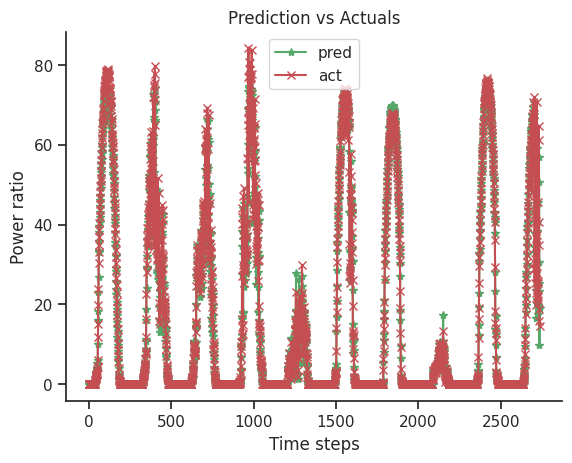

In [82]:
plot_pred_vs_act(preds, acts, ylabel="Power ratio")

# Building Target model

In [84]:
TL_CONFIG = dict(
            features=['temperature', 'humidity', 'GHI-Pyranometer', 'Power-EL'],
            label='Power-EL',
            input_size=70,
            horizon=1,
            batch_size=64,
            num_channels = [20] * 4,
            in_channels = 4,
            learning_rate=0.0008,
            scale=False,
            train=False,
            train_dataset_size = 0.8,
            val_dataset_size=0.1,
            test_dataset_size=0.1,
            )

In [85]:
wandb_logger = WandbLogger(project="Transfer Learning DKASC dataset training", log_model="all", prefix="target_model", reinit=True)

In [86]:
# pv = pd.read_csv("/kaggle/input/pv-logs/Power-Clausthal(in).csv", sep=';', decimal=',', usecols=['temperature', 'humidity', 'GHI-Pyranometer', 'Power-EL'])
# pv['Power-EL'] = pv['Power-EL'] / pv['Power-EL'].max() * 100
# pv.loc[pv['Power-EL'] <= 0.01, 'Power-EL'] = 0.02
# pv.loc[pv['GHI-Pyranometer'] <= 0.01, 'GHI-Pyranometer'] = 0.02
# pv = pv[['temperature', 'humidity', 'GHI-Pyranometer', 'Power-EL']]
# pv.to_csv("TU-Clausthal-PV-2023-08-09.csv", index=False)
# pv.describe()
# train_dataset_size = int(len(pv) * TL_CONFIG['train_dataset_size'])
# val_dataset_size = train_dataset_size + int(len(pv) * TL_CONFIG['val_dataset_size'])

# if TL_CONFIG["scale"] != True:
#     train_dataset_csv = pv[:train_dataset_size].reset_index(drop=True)
# else:
#     ss = StandardScaler()
#     train_dataset_csv = pd.DataFrame(ss.fit_transform(pv[:train_dataset_size].reset_index(drop=True)))
    
# train_dataset_csv.to_csv("TU-Clausthal-PV-train.csv", index=False)
# pv[train_dataset_size:val_dataset_size].reset_index(drop=True).to_csv("TU-Clausthal-PV-val.csv", index=False)
# pv[val_dataset_size:].reset_index(drop=True).to_csv("TU-Clausthal-PV-test.csv", index=False)

In [87]:
class PVTLDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 32, horizon: int=1, input_size: int = 12):
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.batch_size = batch_size
        self.horizon = horizon
        self.input_size = input_size
    
    def prepare_data(self):
        pass
        
    def setup(self, stage=None):
        if stage == 'fit':
            self.pv_train = DKACS("/kaggle/working/TU-Clausthal-PV-train.csv", self.horizon, self.input_size)
            self.pv_val = DKACS("/kaggle/working/TU-Clausthal-PV-val.csv", self.horizon, self.input_size)
        
        if stage == 'test':
            self.pv_test = DKACS("/kaggle/working/TU-Clausthal-PV-test.csv", self.horizon, self.input_size)
        
        if stage == 'predict':
            self.pv_test = DKACS("/kaggle/working/TU-Clausthal-PV-test.csv", self.horizon, self.input_size)

    
    def train_dataloader(self):
        return DataLoader(self.pv_train, shuffle=False, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(self.pv_val, shuffle=False, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    def test_dataloader(self):
        return DataLoader(self.pv_test, shuffle=False, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    def predict_dataloader(self):
        return DataLoader(self.pv_test, shuffle=False, num_workers=3, batch_size=self.batch_size, drop_last=True)
    
    def teardown(self, stage):
        if stage == 'fit':
            del self.pv_train
            del self.pv_val
            
        if stage == 'test':
            del self.pv_test

In [88]:
class TL(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate

        model = TCNETANetLSTM.load_from_checkpoint(Path(artifact_dir) / "model.ckpt",
                                                   in_channels=CONFIG['in_channels'],
                                                   num_channels=CONFIG['num_channels'],
                                                   learning_rate=CONFIG['learning_rate'],
                                                   batch_size=CONFIG['batch_size'])
        model.freeze()
        self.feature_extractor = nn.Sequential(model.network, model.permute_layer, model.gru)
        self.flatten = nn.Flatten()
        self.criterion = nn.L1Loss()
        self.output_layer = nn.LazyLinear(1)
        
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        x = x[0]
        x = self.flatten(x)
        return x
    
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def forward(self, x):
        x = self._forward_features(x)
        x = x.contiguous().view(x.size(0), -1)
        x = self.output_layer(x)
        return x
    
    def training_step(self, batch):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)
        self.log('loss_epoch', loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        predictions = self(batch)
        loss = self.criterion(predictions, gt)
        loss_mse = nn.functional.mse_loss(predictions, gt)
        self.log('test_MAE_loss', loss, logger=True)
        self.log("test_mse_loss", loss_mse, logger=True)
        return {"prediction": predictions, "actual": gt, "loss_mae": loss, "loss_mse": loss_mse}
    
    def predict_step(self, *args, **kwargs):
        batch = kwargs.get("batch", args[0])
        predictions = self(batch)
        actual_values = batch[1]
        return predictions, actual_values
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def on_test_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        plot_pred_vs_act(outputs['prediction'], outputs['actual'], ylabel="Power output ratio")

In [89]:
pv_datamodule = PVTLDataModule(batch_size=TL_CONFIG["batch_size"], horizon=TL_CONFIG['horizon'], input_size=TL_CONFIG['input_size'])
target_model = TL(learning_rate=TL_CONFIG['learning_rate'])

/kaggle/working/libs/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.3.2
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [90]:
sweep_config = {
    "method": "random",
    "metric": {"goal": "minimize", "name": "target_model-val_loss"},
    "parameters": {
        'batch_size': {
            'distribution': 'q_log_uniform_values',
            'q': 8,
            'min': 32,
            'max': 256},
        "learning_rate": {"distribution": "log_uniform", "max": -4.46, "min": -11.6},
        "input_size": {
            'distribution': 'q_log_uniform_values',
            'q': 2,
            'min': 12,
            'max': 96},
        "horizon": {"value": 1},
        "in_channels": {"value": 4},
    }
}

In [91]:
def sweep_it(config=None):
    wandb.init()
    wandb_logger = WandbLogger(project="Transfer Learning DKASC dataset training",
                                   log_model="all",
                                   prefix="target_model",
                                   config=config,
                                   reinit=True
                                  )
    config = wandb.config
    wandb_logger.log_metrics
    try:
        pv_dm = PVTLDataModule(input_size=config['input_size'], horizon=config['horizon'], batch_size=config["batch_size"])
        model = TL(learning_rate=config['learning_rate'])
        trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, enable_progress_bar=True)
        start = datetime.now()
        trainer.fit(model, pv_dm)
        end = datetime.now()
        print(f"Training took {end - start} seconds")
        trainer.test(model, dkasc_datamodule)
    except Exception as exc:
        print(exc)       
        exit()
    finally:
        wandb.finish()

In [92]:
sweep = False
if sweep is True:
    sweep_id = wandb.sweep(sweep_config, project="Transfer Learning DKASC dataset training",)    
    wandb.agent(sweep_id, sweep_it, count=75)

In [93]:
callbacks = [
        ModelCheckpoint(monitor="val_loss", filename='{epoch}-{val_loss:.2f}'),
        EarlyStopping('val_loss', patience=5)
            ]

In [94]:
trainer = pl.Trainer(max_epochs=200, logger=wandb_logger, callbacks=callbacks, log_every_n_steps=10)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [95]:
if TL_CONFIG['train']:
    trainer.fit(target_model, datamodule=pv_datamodule)

In [96]:
target_model_id = "model-es3zxw7d"
# model_id = "model-0xv5a270"

target_local_artifacts = list(Path("").glob(f"**/{target_model_id}*"))
if not target_local_artifacts:
    target_artifact = wandb.run.use_artifact(f'hz33co/Transfer Learning DKASC dataset training/{target_model_id}:best', type='model')
    target_artifact_dir = target_artifact.download()
else:
    target_artifact_dir = target_local_artifacts[-1]


In [97]:
target_model = TL.load_from_checkpoint(Path(target_artifact_dir) / "model.ckpt", model="model")

/kaggle/working/libs/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Testing: |          | 0/? [00:00<?, ?it/s]

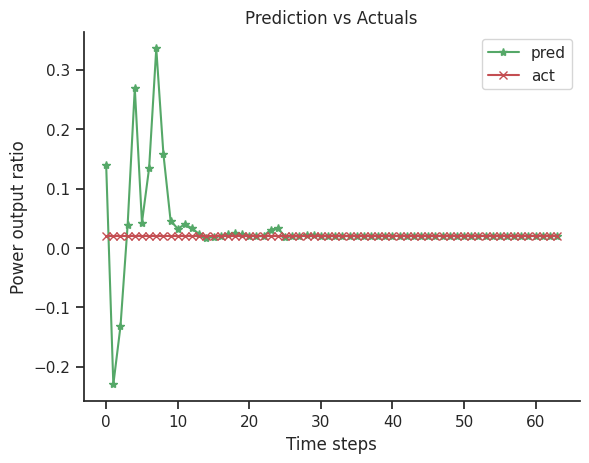

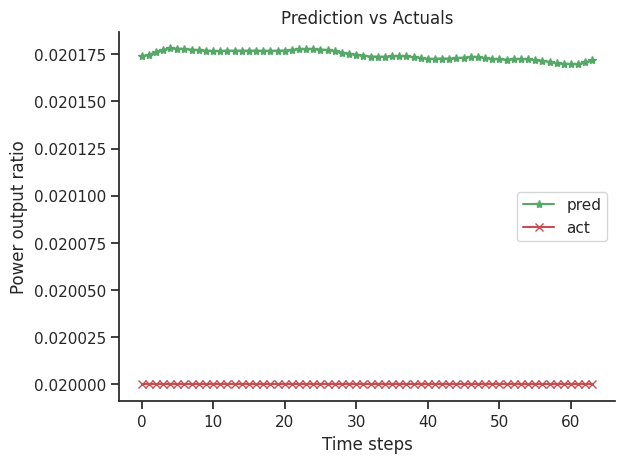

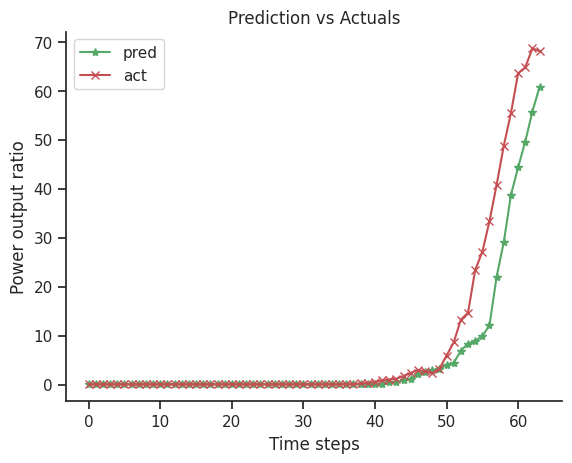

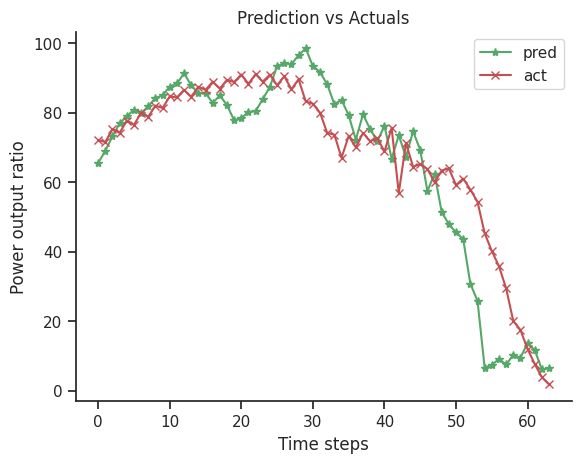

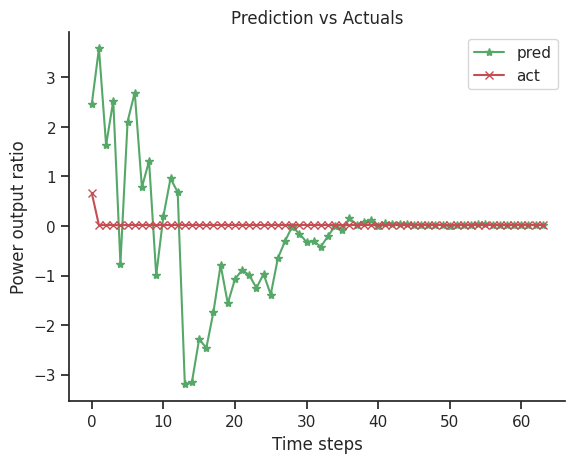

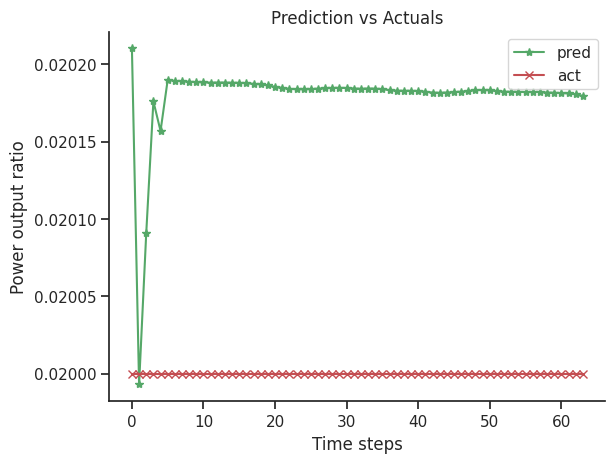

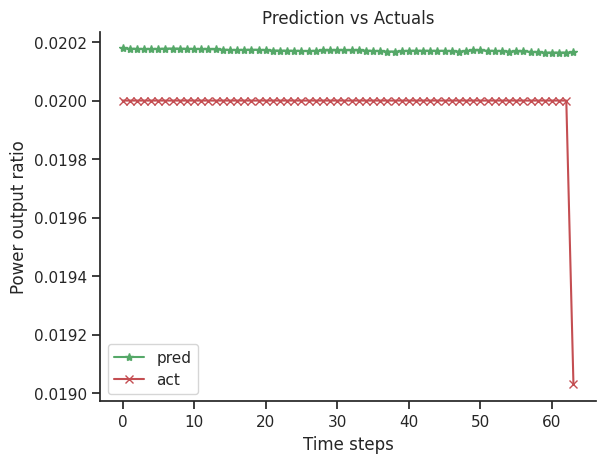

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MAE_loss       │    1.7652703523635864     │
│       test_mse_loss       │     26.81632423400879     │
└───────────────────────────┴───────────────────────────┘

[{'test_MAE_loss': 1.7652703523635864, 'test_mse_loss': 26.81632423400879}]

In [98]:
trainer.test(model=target_model, datamodule=pv_datamodule)

In [ ]:
predictions = trainer.predict(model=target_model, datamodule=pv_datamodule)